In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy

from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
%matplotlib inline

#print multiple statements in same line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"

In [2]:
list_texts = pd.read_csv('datasets\dataFinal2.csv')
list_texts.shape

(5752, 2)

In [3]:
list_texts['Content'].sample(2)

5721    therapy diabetes supplements vitamins
4232              overweight obese least risk
Name: Content, dtype: object

In [4]:
nan_value = float("NaN")
#Convert NaN values to empty string

list_texts.replace("", nan_value, inplace=True)

list_texts.dropna(subset = ["Content"], inplace=True)
list_texts.shape

(5752, 2)

In [5]:
list_texts['Content'].sample(2)

4010    needle syringe insulin pump
4819    pump connects small plastic
Name: Content, dtype: object

In [6]:
doc = nlp("Carbohydrate counting involves keeping track of the amount of carbohydrates you eat and drink each day.")
    
for tok in doc:
  print(tok.text, "  >     ", tok.dep_)


Carbohydrate   >      compound
counting   >      nsubj
involves   >      ROOT
keeping   >      xcomp
track   >      dobj
of   >      prep
the   >      det
amount   >      pobj
of   >      prep
carbohydrates   >      pobj
you   >      nsubj
eat   >      relcl
and   >      cc
drink   >      conj
each   >      det
day   >      npadvmod
.   >      punct


### Function to extract the subject and the object (entities) from a sentence.

In [7]:
def getentities_fromtext(sent):
  ## part  1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence
  prefix = ""
  modifier = ""  
  for tok in nlp(sent):
    ## part 2
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [8]:
getentities_fromtext("Because carbohydrates turn into glucose in your body, they affect your blood glucose level")

['they', 'blood glucose level']

In [9]:
pairs_entity = []
for i in tqdm(list_texts["Content"]):
  pairs_entity.append(getentities_fromtext(i))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5752/5752 [00:22<00:00, 256.80it/s]


In [10]:
len(pairs_entity)

5752

### Using spaCy rule-based matching:

In [11]:
def get_relation(sent):
  doc = nlp(sent)
  # Matcher class object 
  matcher = Matcher(nlp.vocab)
  
  #define the pattern 
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':"?"},{'DEP':'agent','OP':"?"},{'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 
  return(span.text)

In [12]:
# test the function
get_relation("Because carbohydrates turn into glucose in your body")

'turn into'

In [13]:
relations = [get_relation(i) for i in tqdm(list_texts['Content'])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5752/5752 [00:23<00:00, 247.02it/s]


In [14]:
relationS_freq = pd.Series(relations).value_counts()[:20]
relationS_freq

diabetes     312
take         156
help         154
need          80
make          65
develop       53
manage        53
include       49
health        48
care          47
insulin       46
learn         42
called        42
medicines     41
glucose       41
prevent       40
cause         40
causes        36
test          35
helps         33
dtype: int64

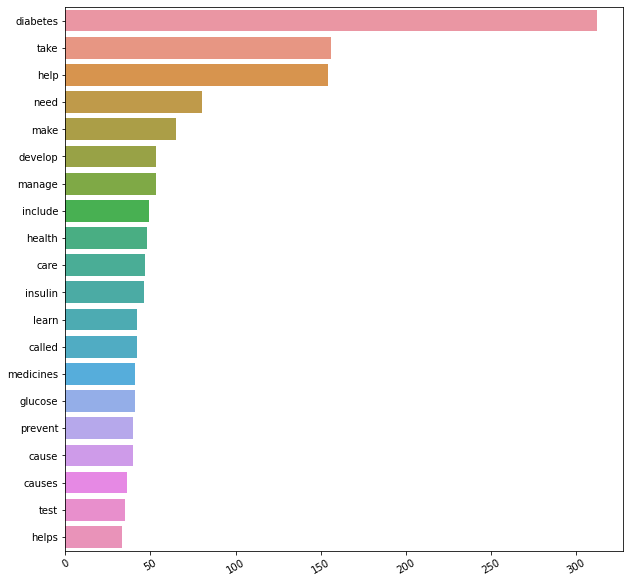

In [15]:
import seaborn as sns

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(relationS_freq))
all_fdist

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(y=all_fdist.index, x=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

In [16]:
# extract subject
source = [i[0] for i in pairs_entity]

# extract object
target = [i[1] for i in pairs_entity ]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [17]:
import numpy as np
kg_df = kg_df.dropna(axis='rows', how='all')

In [18]:
kg_df.dtypes
kg_df.shape
kg_df

source    object
target    object
edge      object
dtype: object

(5752, 3)

,source,target,edge
0,,diabetes care record,abcs
1,,doctor,take
2,,diabetes meal,abcs
3,,blood,help
4,,diabetes,abcs
...,...,...,...
5747,thyroid gland,much,produces much
5748,,,removal
5749,,,simple
5750,gestational diabetes,,goes


In [19]:
print (kg_df.columns)

Index(['source', 'target', 'edge'], dtype='object')


In [20]:
kg_df1 = kg_df[kg_df.target != '']
kg_df1.shape
kg_df1 = kg_df[kg_df.source != '']
kg_df1.shape
kg_df2 = kg_df1[kg_df.target != '']
kg_df2.shape
kg_df2

(2709, 3)

(2194, 3)

(1157, 3)

,source,target,edge
6,help,talk,able
19,acromegaly,body,produces
20,action factors,help,change
30,active help,blood,keep
31,active help,prediabetes,prevent
...,...,...,...
5725,therapy,diabetes,improve
5731,things,lower risk,change lower
5732,diabetes,genes,think
5738,tests,confirm,described


<Figure size 864x864 with 0 Axes>

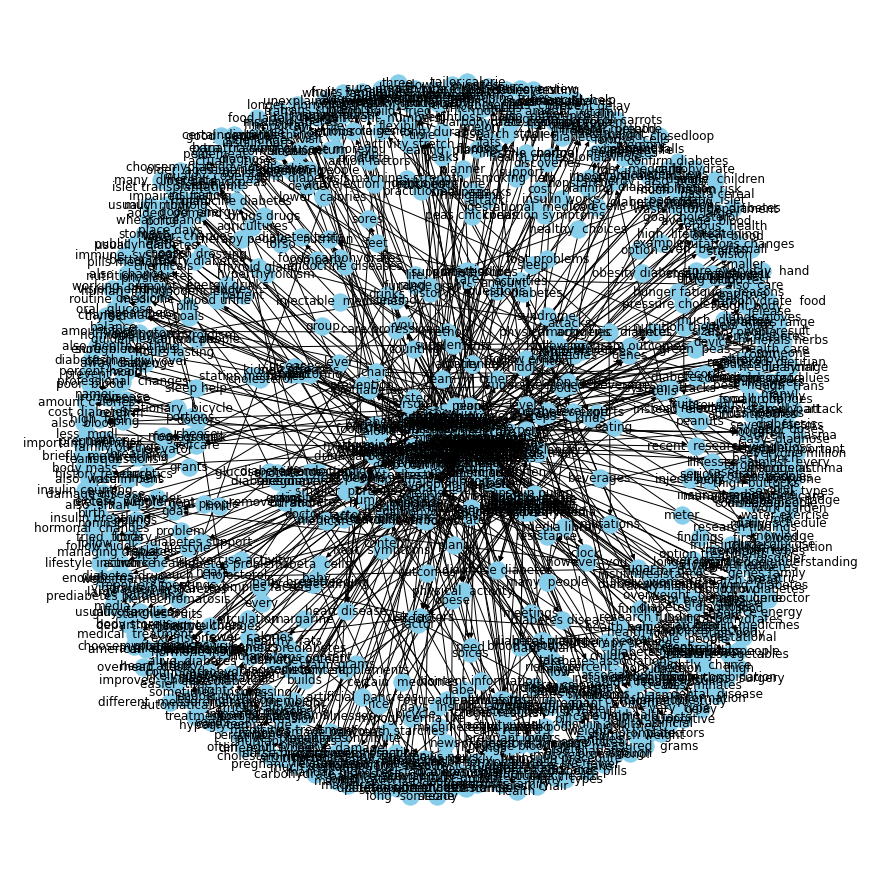

In [21]:
G = nx.from_pandas_edgelist(kg_df2, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

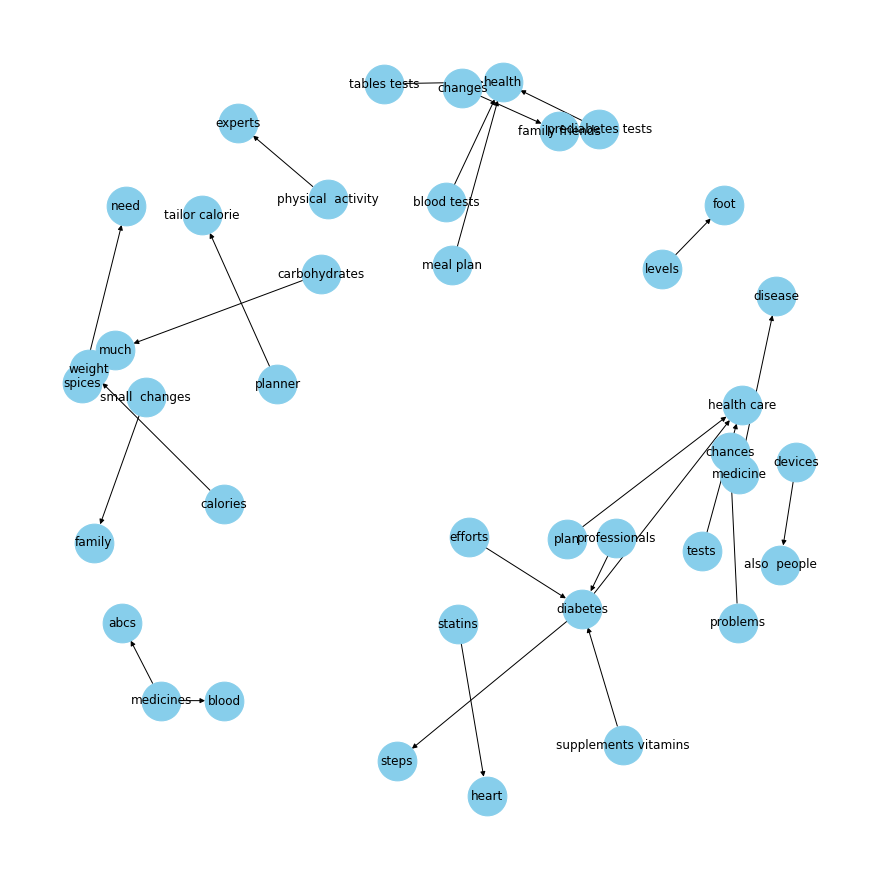

In [22]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="help"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.savefig("datasets\Graph.png", format="PNG")
plt.show()

<Figure size 864x864 with 0 Axes>

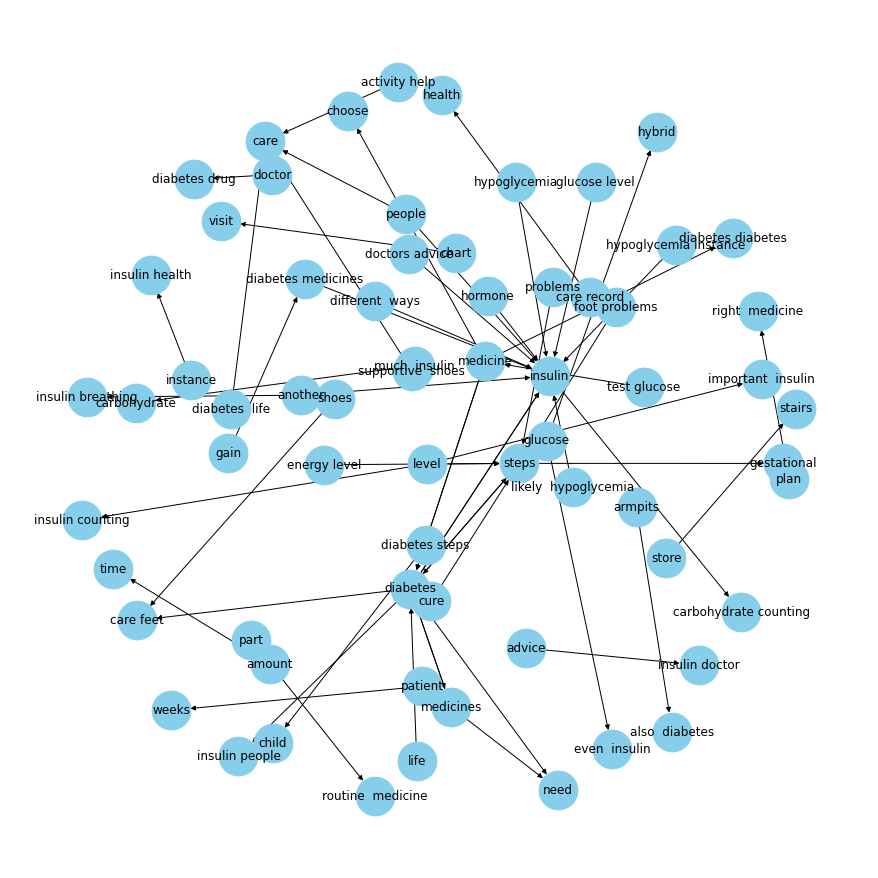

In [23]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="take"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

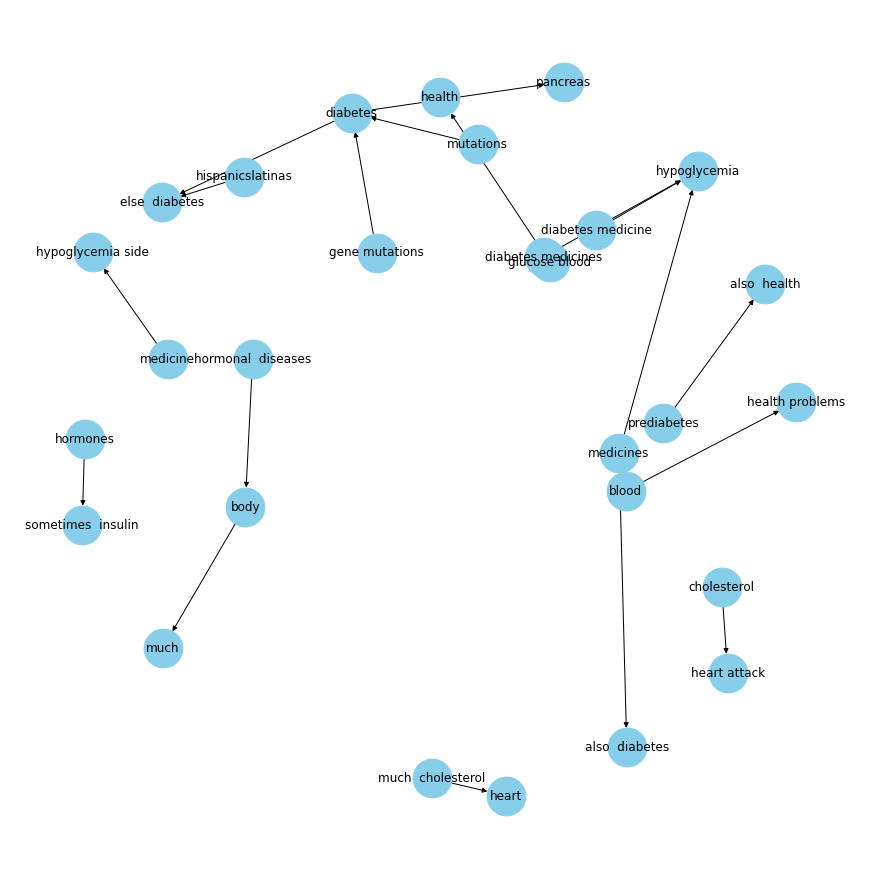

In [24]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="cause"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

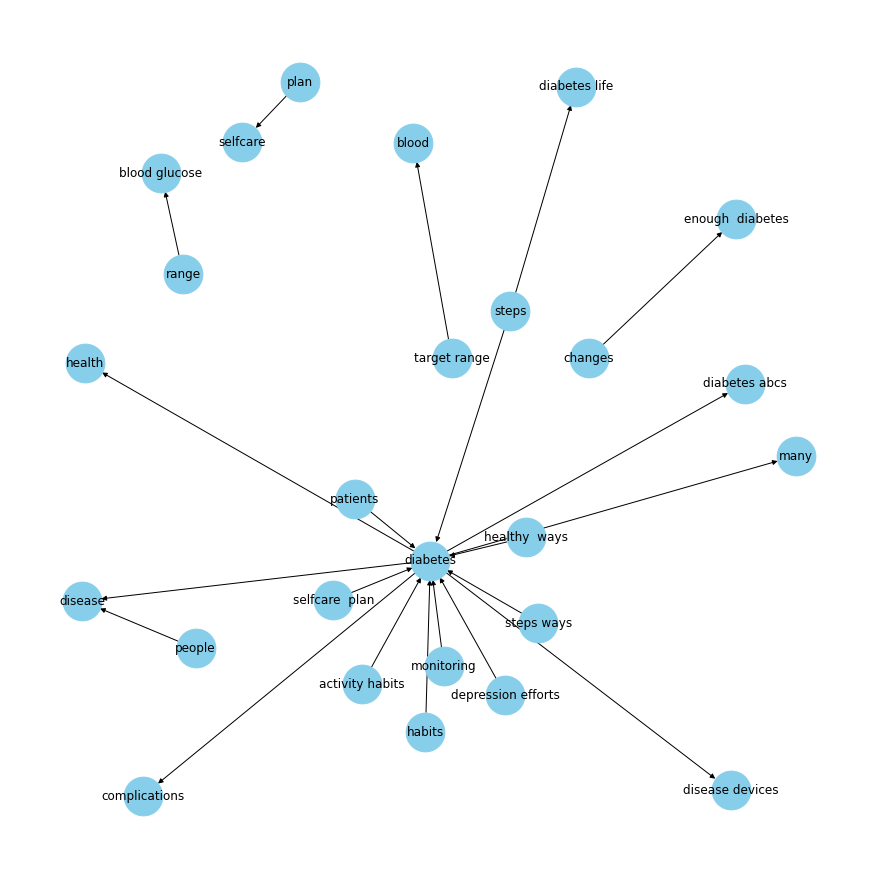

In [36]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="manage"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

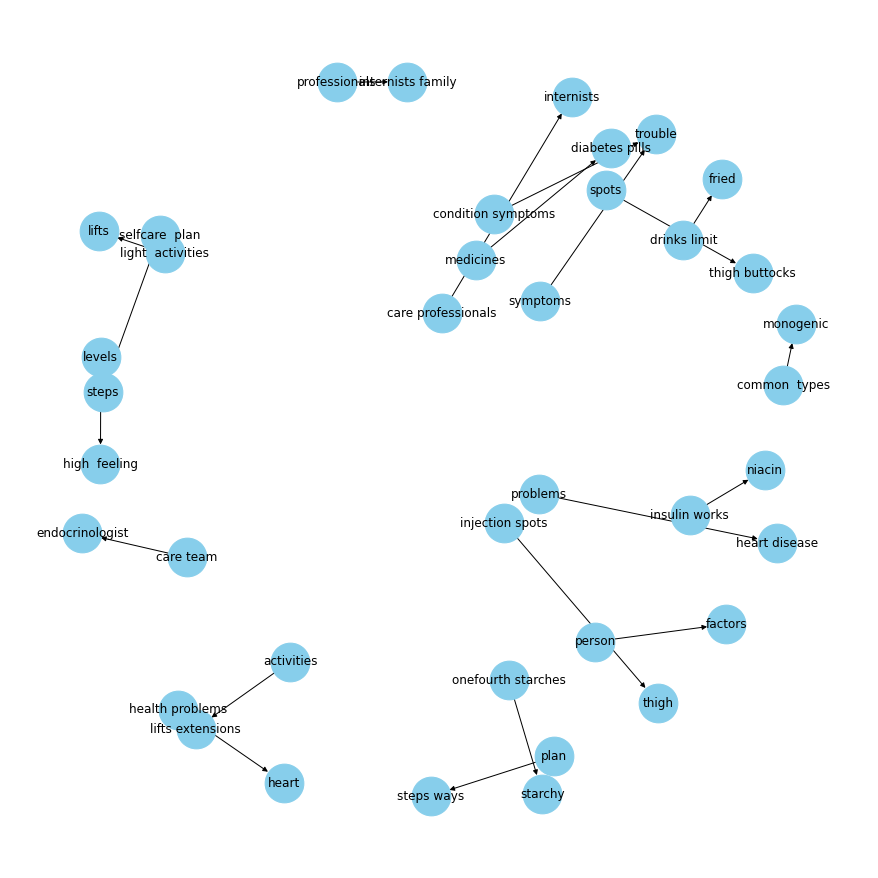

In [26]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="include"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

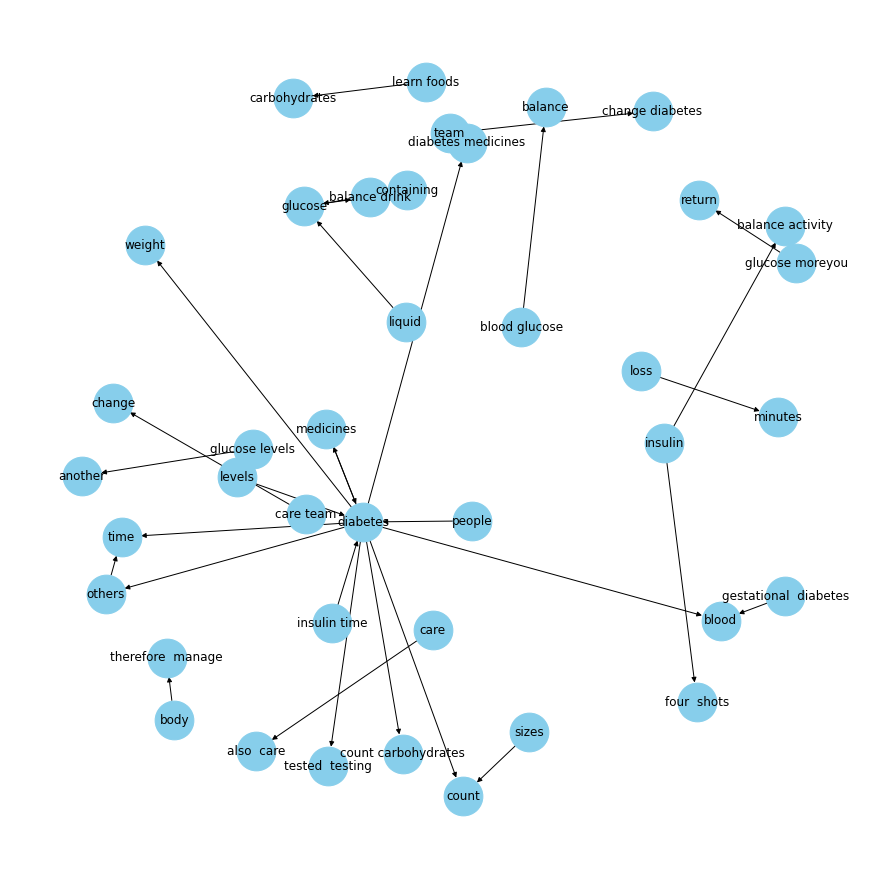

In [27]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="need"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

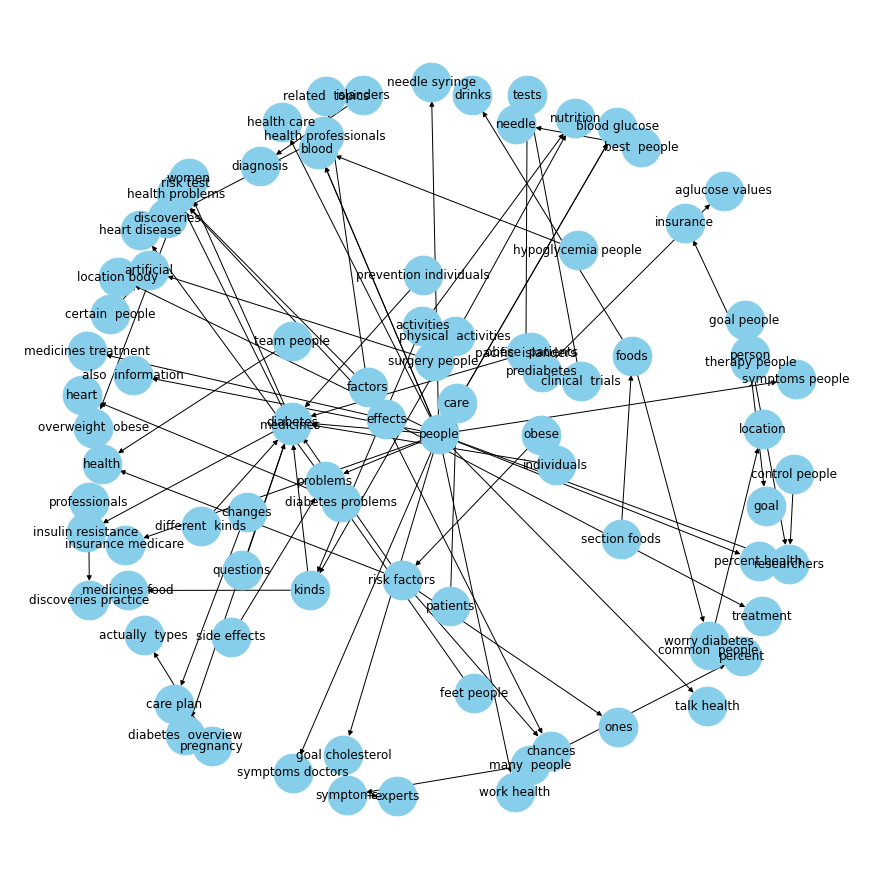

In [28]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="diabetes"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

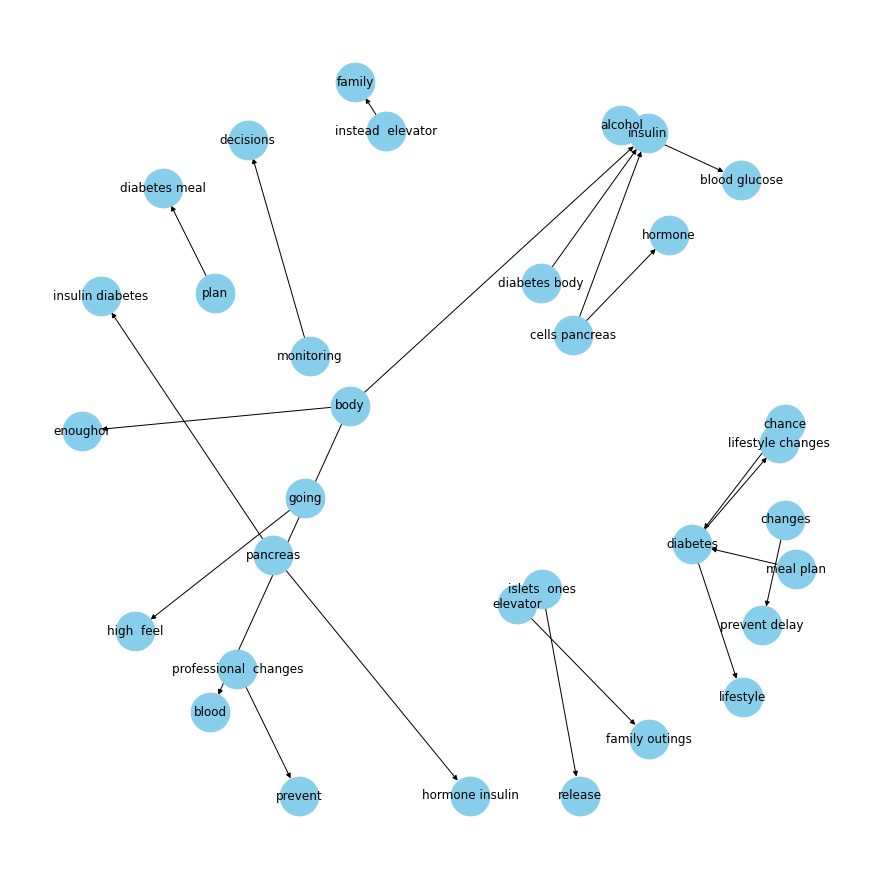

In [29]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="make"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

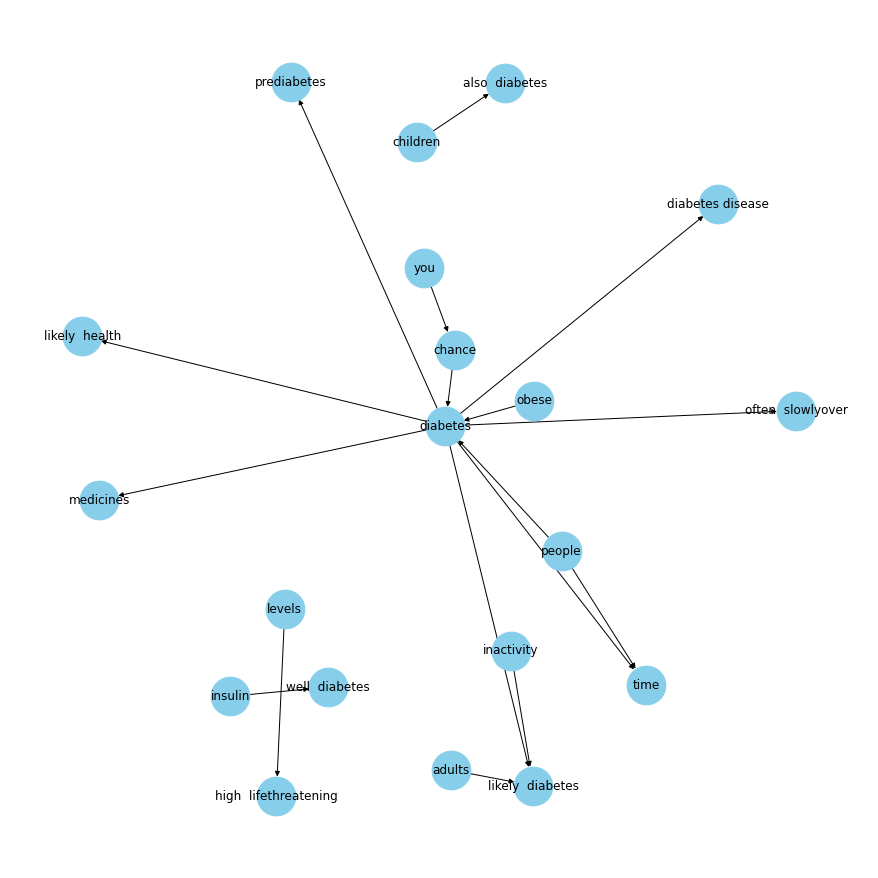

In [30]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="develop"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

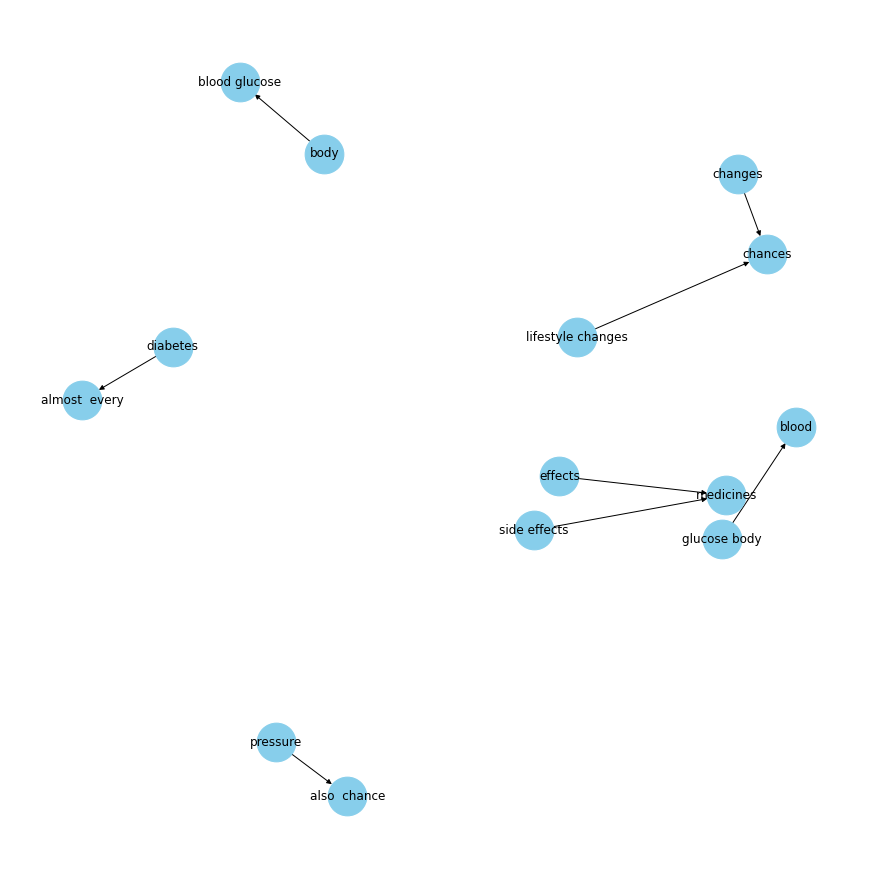

In [31]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="affect"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

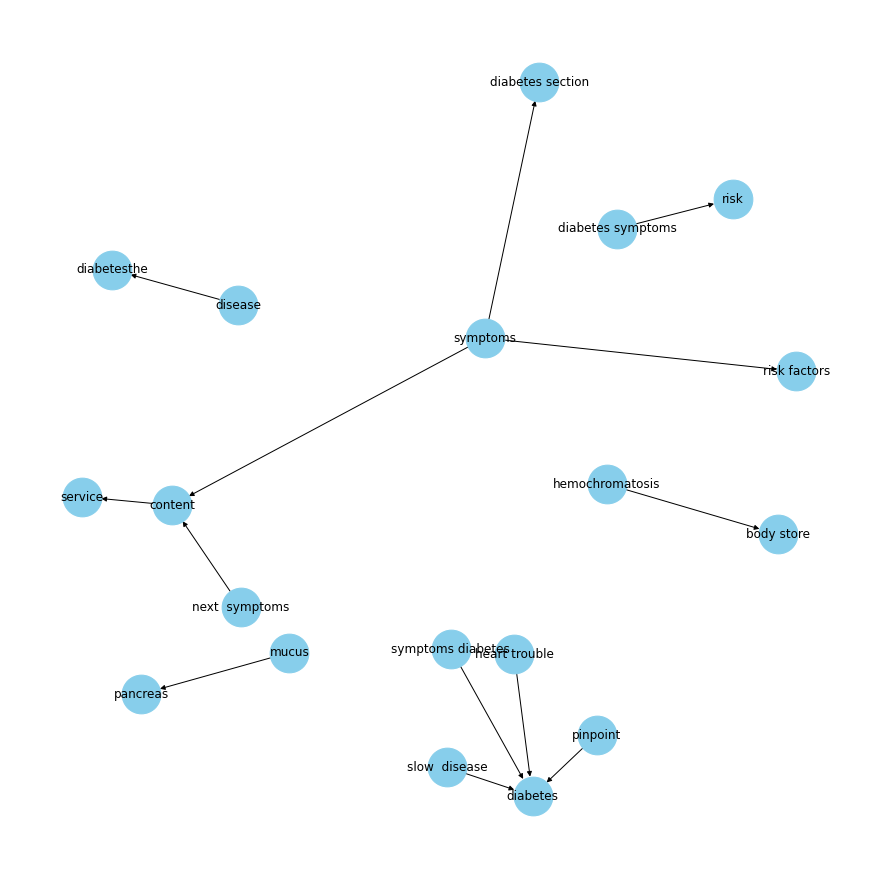

In [37]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="causes"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

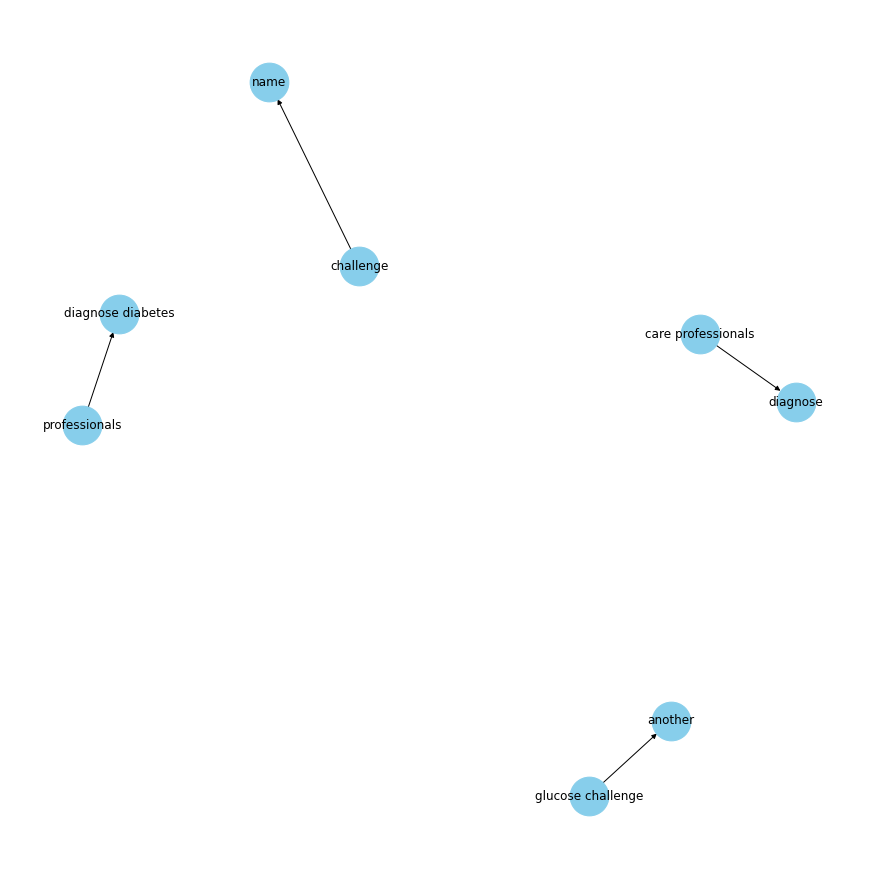

In [35]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="test"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

<Figure size 864x864 with 0 Axes>

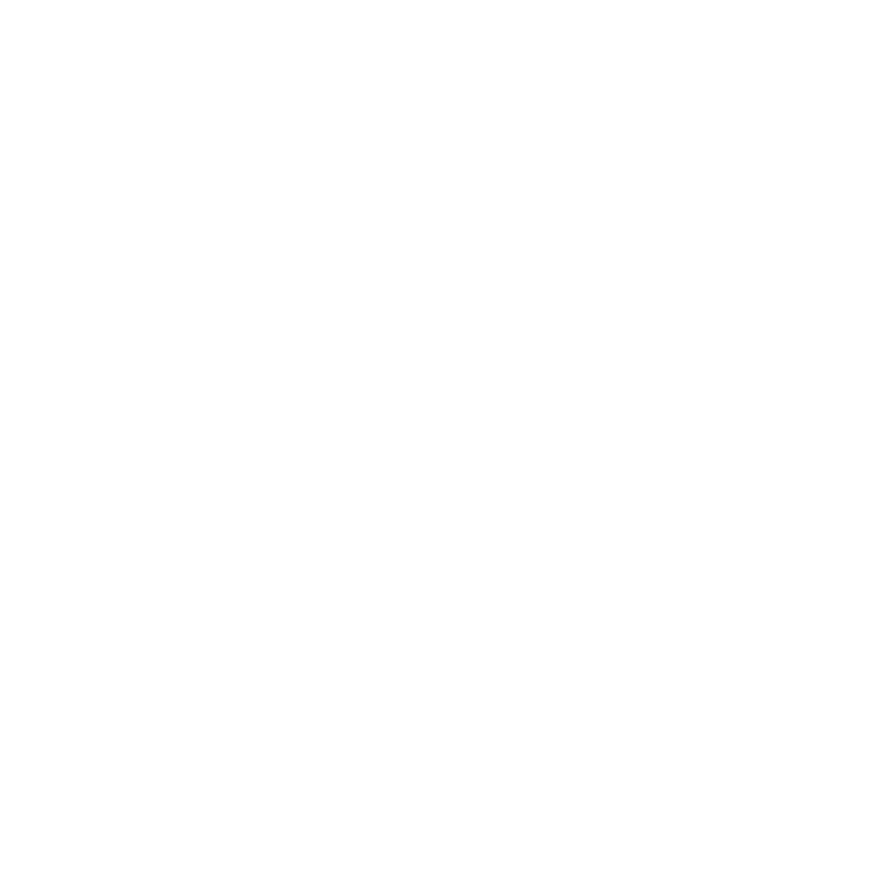

In [38]:
G=nx.from_pandas_edgelist(kg_df2[kg_df2['edge']=="health"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()